In [1]:
import os
import sys
import time
import fnmatch
import warnings
import importlib

import torch

import numpy as np

import GPy
import paramz
import tables
from GPy.core.parameterization.priors import Gamma, InverseGamma, Gaussian
import emcee
import corner

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython import display

import scipy.interpolate
from scipy.integrate import trapezoid

import h5py

from ps_eor import datacube, pspec, psutil, simu, fitutil, fgfit, flagger, ml_gpr, obssimu

import astropy.units as u
import astropy.constants as const
import astropy.stats as astats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

%matplotlib inline

plt.style.use('~/.local/share/libwise/mnras2.preset')

# Purpose of this notebook

- Produce the figures with the results of the test scenarios

# Load the VAE and IAE and define global variables

In [3]:
PATH = '../codes'
sys.path.insert(1,PATH)
import IAE_JAX_v2_devl_08_09_21 as iae

class IAEFitter(ml_gpr.AbstractFitter):

    def __init__(self, model, k_mean, simplex=False): # k_mean ????
        if simplex:
            ndim = model["AnchorPoints"].shape[0]-1
        else:
            ndim = model["AnchorPoints"].shape[0]
        ml_gpr.AbstractFitter.__init__(self, ndim, k_mean)
        lf = iae.IAE(Model=model)
        self.simplex = simplex
        self.lf = lf
        self.model = model
        self.y_min = np.zeros((ndim,))
        self.y_max = np.zeros((ndim,))
        self.ndim = ndim

    def get_latent_space_boundaries(self,data):
        L = self.lf.fast_interpolation(data)["Lambda"]
        if self.simplex:
            L = L[:,0:self.ndim] # need to check that
        self.y_min = np.min(L,axis=0)
        self.y_max = np.max(L,axis=0)

    def decode(self,data):
        if self.simplex:
            u = ml_gpr.jnp.hstack((data.squeeze(), 1 - jnp.sum(data))) # We might remove the samplew constraint
        else:
            u = data.squeeze() # We might remove the samplew constraint
        return self.lf.get_barycenter(u)

    def encode(self,data):
        return self.lf.encoder(data)

    def reconstruct(self, data):
        return self.lf.decoder(self.lf.encoder(data))

    @staticmethod
    def load(filename):
        model = ml_gpr.joblib.load(filename)
        k_mean = np.array([0.05730528, 0.08320909, 0.11519442, 0.16067338, 0.22356231,
                   0.30937082, 0.42911561, 0.59454327, 0.82347184, 1.10628762,
                   1.54903247, 2.11011604])
        fitter = IAEFitter(model, k_mean)
        return fitter


class IAEKern(ml_gpr.AbstractMLKern, ml_gpr.MultiKern):
    ''' ML Kernel implementation '''

    def __init__(self, iae_fitter, name='iae_kern', param_values=[]):
        self.fitter_res = iae_fitter
        self.ps3d_k_mean = iae_fitter.k_mean
        ml_gpr.AbstractMLKern.__init__(self, iae_fitter.n_dim, name=name, param_values=param_values)

    def copy(self):
        c = IAEKern(self.fitter_res, name=self.name)
        c.copy_params(self)

        return c

    def set_latent_space_prior(self):
        ''' Convenient function to set a Uniform prior on the latent space parameters '''
        for param, mini, maxi in zip(self.parameters[:-1], self.fitter_res.y_min, self.fitter_res.y_max):
            param.set_prior(ml_gpr.Uniform(mini, maxi))

    def get_norm_cov_1d(self, freqs, params):
        cov_gen = ml_gpr.get_cached_cov_gen(tuple(freqs), tuple(self.uv_bins))
        ps3d = self.fitter_res.decode(params).squeeze()
        ps3d = self.ps3d_k_mean ** 1 * ps3d

        return cov_gen.c_nu_from_ps21(self.ps3d_k_mean, ps3d)

    @staticmethod
    def load_from_dict(name, d):
        iae_fitter = IAEFitter.load(d['fitter_filename'])
        kern = IAEKern(iae_fitter, name=name)
        return ml_gpr.MultiKern._parse_set_params_from_dict(kern, d)
    
def add_cosmic_variance(ps_eor, ps_ref):
    errs = np.random.normal(loc=0, scale=ps_ref.err[:, None], size=(len(ps_ref.k_mean), len(ps_eor.all_ps)))
    all_ps = [ps.new_with_data(ps.data + err, 0) for ps, err in zip(ps_eor.all_ps, errs.T)]
    return pspec.SphericalPowerSpectraMC(all_ps)


In [4]:
du = 20
umin = 35
umax = 300
uv_bins = psutil.pairwise(np.arange(umin, umax + du, du))

freqs = np.arange(122, 134, 0.2) * 1e6

img_res = 0.000306
n_pix = 256

latent_dim = 2
n_s = 500

In [5]:
ps3d_ref = pspec.SphericalPowerSpectra.load_from_txt('ps_signal/ps3d_21cmFast_ref_no_ts_fluct_3params_2.txt')

c_eor = 0.9 * ml_gpr.make_new_vis_cube_from_ps(ps3d_ref.k_mean, ps3d_ref.data, img_res, n_pix, freqs, umin, umax)

In [6]:
dec_deg = -30
hal = -5
har = 5

tel_simu = obssimu.TelescopeSimu(obssimu.SkaLow(), freqs, dec_deg, hal, har, umin=umin, umax=umax,  timeres=200, remove_intra_baselines=True)
simu_grid = tel_simu.image_gridding(np.degrees(c_eor.meta.theta_fov), oversampling_factor=1 / (img_res * umax), min_weight=0.1).get_tel_gridded_uv()

total_time_hour = 100
c_noise = simu_grid.weights.simulate_noise(simu_grid.get_sefd(), total_time_hour * 3600, hermitian=False)

Simulating UV coverage ...
Number of elements: 513
Number of baselines: 131328
 Progress: 180 / 180 (Total: 20.30 s) 
Gridding UV coverage ...
 Progress: 60 / 60 (Total: 11.92 s) 


In [7]:
ps_build = pspec.PowerSpectraBuilder()
ps_gen = ps_build.get(c_eor, du=10, umax=umax, umin=umin + 5, rmean_freqs=False, window_fct='hann')
kbins = np.logspace(np.log10(ps_gen.kmin), np.log10(1), 9)

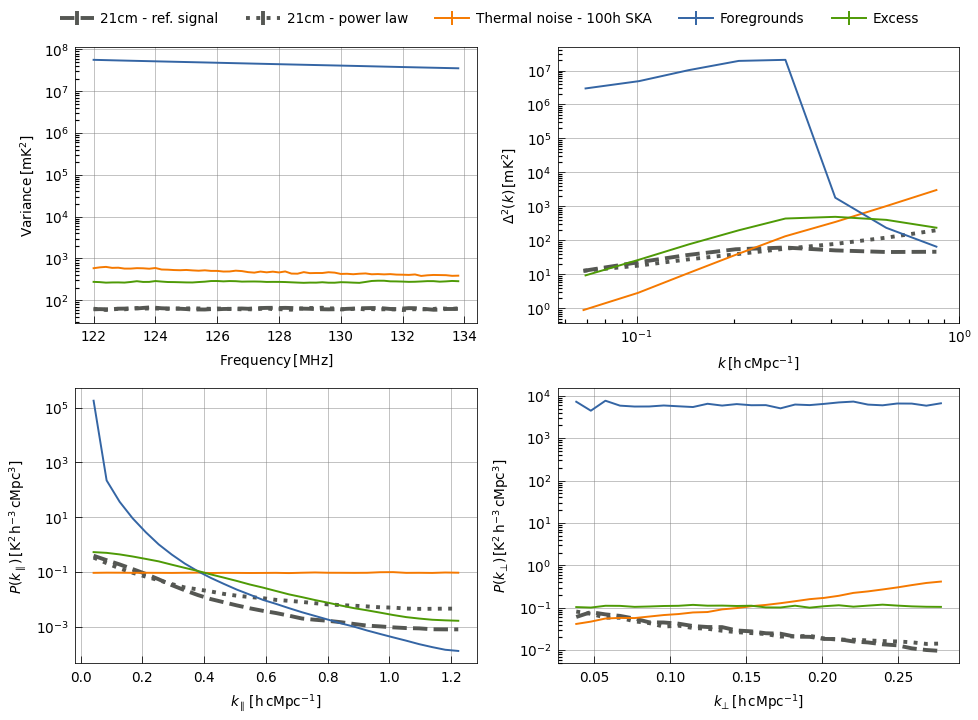

In [8]:
k_fg = ml_gpr.MMat52(variance=0.01 / 400., lengthscale=4, name='fg1', ls_alpha=1)
k_fg += ml_gpr.MRBF(variance=0.01, lengthscale=80, name='fg2')

c_fg = ml_gpr.make_new_vis_cube(img_res, n_pix, freqs, umin, umax, kern=k_fg, uv_bins_du=du)
c_fg.data = c_fg.data * (c_fg.freqs / c_fg.freqs[0])[:, None] ** -2.5

k_excess = ml_gpr.MMat52(variance=0.025 / 5e5, lengthscale=0.4, name='fg')
c_excess = ml_gpr.make_new_vis_cube(img_res, n_pix, freqs, umin, umax, kern=k_excess)

k_mean = np.logspace(np.log10(0.05), np.log10(2.5), 14)
ps3d_fct = lambda k: 1 * k ** 1
c_eor_power_law = ml_gpr.make_new_vis_cube_from_ps(k_mean, ps3d_fct(k_mean), img_res, n_pix, freqs, umin, umax, uv_bins_du=du)
c_eor_power_law = (c_eor.data.var() / c_eor_power_law.data.var()) ** .5 * c_eor_power_law
c_eor_power_law.weights = c_noise.weights.copy()

c_eor.weights = c_noise.weights.copy()

fp = pspec.FourPanelPsResults(ps_gen, kbins, figsize=(7.1, 5))
fp.add_cube(c_eor, '21cm - ref. signal', marker='', nsigma=0, c=psutil.black, ls='--', lw=2)
fp.add_cube(c_eor_power_law, '21cm - power law', marker='', nsigma=0, c=psutil.black, ls=':', lw=2)
fp.add_cube(c_noise, 'Thermal noise - 100h SKA', marker='', nsigma=0, c=psutil.orange)
fp.add_cube(c_fg, 'Foregrounds', marker='', nsigma=0, c=psutil.blue)
fp.add_cube(c_excess, 'Excess', marker='', nsigma=0, c=psutil.green)
fp.done(5)
fp.savefig('figures/ps_all_components_v2.pdf')

In [45]:
import functools

@functools.lru_cache
def get_ps_eor(save_dir, save_name, sampler_method, n_pick=50):
    ml_gpr_res = ml_gpr.MLGPRResult.load(save_dir, save_name, sampler_method)
    return ml_gpr_res.get_ps_eor(ps_gen, kbins, n_pick=n_pick)

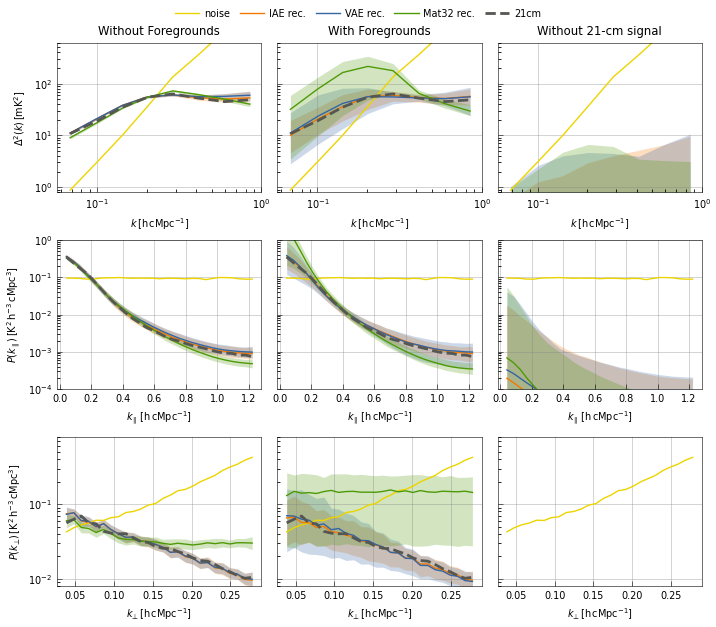

In [85]:
total_time_hour = 100

tests = ['no_fg', 'fg', 'no_21']
sampler = ['ultranest', 'mcmc', 'ultranest']
n_picks = [51, 50, 500]

fp = pspec.ThreePanelPsResults(ps_gen, kbins, figsize=(7.1, 6), n_cols=3)

for i, (test, s_m, n_pick) in enumerate(zip(tests, sampler, n_picks)):
    ps_eor_iae = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'iae', s_m, n_pick=n_pick)
    ps_eor_vae = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'vae', s_m, n_pick=n_pick)
    ps_eor_m32 = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'm32', s_m, n_pick=n_pick)

    fp.add_cube(c_noise, 'noise', marker='', c=psutil.yellow, nsigma=0, col=i)
    
    fp.add_ps_stacker(ps_eor_iae, 'IAE rec.', c=psutil.orange, show68=False, marker='', col=i)
    fp.add_ps_stacker(ps_eor_vae, 'VAE rec.', c=psutil.blue, show68=False, marker='', col=i)
    fp.add_ps_stacker(ps_eor_m32, 'Mat32 rec.', c=psutil.green, show68=False, marker='', col=i)
    
    if i < 2:
        fp.add_cube(c_eor, '21cm', c=psutil.black, lw=2, marker='', nsigma=0, col=i, ls='--')
        
for ax in fp.axs.flatten():
    for c in ax.collections:
        c.set_lw(0)

fp.axs[0, 0].set_ylim(8e-1, 6e2)
fp.axs[1, 0].set_ylim(1e-4, 1e0)
fp.axs[2, 0].set_ylim(8e-3, 8e-1)

fp.axs[0, 0].set_title('Without Foregrounds')
fp.axs[0, 1].set_title('With Foregrounds')
fp.axs[0, 2].set_title('Without 21-cm signal')

fp.done(5, columnspacing=1)
fp.fig.tight_layout(pad=0.2)

fp.savefig('figures/vae+iae_n5000_mcmc_ref_nofg+fg+no21_v2.pdf')

 Progress: 50 / 50 (Total: 13.61 s) 


 Progress: 50 / 50 (Total: 19.57 s) 

 Progress: 50 / 50 (Total: 13.90 s) 


Discarding 1 walkers
 Progress: 50 / 50 (Total: 15.39 s) 


Discarding 1 walkers
 Progress: 50 / 50 (Total: 23.39 s) 


Discarding 1 walkers
 Progress: 50 / 50 (Total: 13.78 s) 


 Progress: 50 / 50 (Total: 12.90 s) 


 Progress: 50 / 50 (Total: 21.81 s) 


 Progress: 50 / 50 (Total: 12.60 s) 


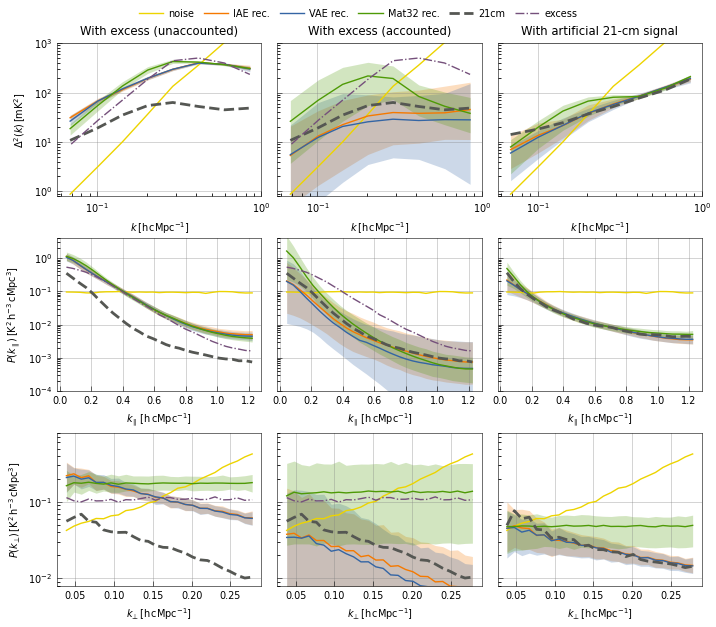

In [86]:
total_time_hour = 100

tests = ['fg_unaccounted_excess', 'fg_accounted_excess', 'fg_power_law_21']
sampler = ['mcmc', 'mcmc', 'mcmc']

fp = pspec.ThreePanelPsResults(ps_gen, kbins, figsize=(7.1, 6), n_cols=3)

for i, (test, s_m) in enumerate(zip(tests, sampler)):
    ps_eor_iae = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'iae', s_m)
    ps_eor_vae = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'vae', s_m)
    ps_eor_m32 = get_ps_eor(f'simulations_results/{test}_{total_time_hour}', 'm32', s_m)

    fp.add_cube(c_noise, 'noise', marker='', c=psutil.yellow, nsigma=0, col=i)
    
    fp.add_ps_stacker(ps_eor_iae, 'IAE rec.', c=psutil.orange, show68=False, marker='', col=i)
    fp.add_ps_stacker(ps_eor_vae, 'VAE rec.', c=psutil.blue, show68=False, marker='', col=i)
    fp.add_ps_stacker(ps_eor_m32, 'Mat32 rec.', c=psutil.green, show68=False, marker='', col=i)
    
    if i < 2:
        fp.add_cube(c_eor, '21cm', c=psutil.black, lw=2, marker='', nsigma=0, col=i, ls='--')
        fp.add_cube(c_excess, 'excess', c=psutil.magenta, lw=1, marker='', nsigma=0, col=i, ls='-.')
    if i == 2:
        fp.add_cube(c_eor_power_law, '21cm', c=psutil.black, lw=2, marker='', nsigma=0, col=i, ls='--')

for ax in fp.axs.flatten():
    for c in ax.collections:
        c.set_lw(0)

fp.axs[0, 0].set_ylim(8e-1, 1e3)
fp.axs[1, 0].set_ylim(1e-4, 4e0)
fp.axs[2, 0].set_ylim(8e-3, 8e-1)

fp.axs[0, 0].set_title('With excess (unaccounted)')
fp.axs[0, 1].set_title('With excess (accounted)')
fp.axs[0, 2].set_title('With artificial 21-cm signal')

fp.done(6, columnspacing=1)
fp.fig.tight_layout(pad=0.2)

fp.savefig('figures/vae+iae_n5000_mcmc_ref_excess_un+excess_v3.pdf')

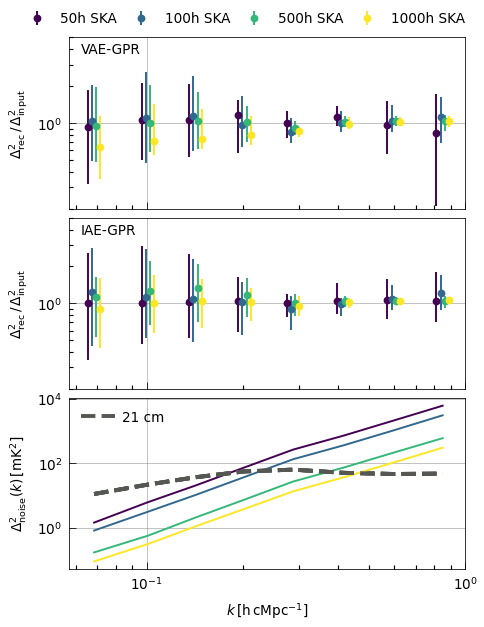

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(3.4, 4.2), nrows=3, sharex=True)
colors = plt.cm.viridis(np.linspace(0, 1, 4))

s_m = 'mcmc'

for c, total_time_hour, o in zip(colors, [50, 100, 500, 1000], [0.955, 0.985, 1.015, 1.045]):
    ml_gpr_res = ml_gpr.MLGPRResult.load(f'simulations_results/fg_{total_time_hour}', 'vae', s_m)

#     ps_gen.get_ps3d(kbins, ml_gpr_res.get_noise_cube()).plot(ax=ax)
    ps_eor_vae = get_ps_eor(f'simulations_results/fg_{total_time_hour}', 'vae', s_m).get_ps3d()
    ps_eor_iae = get_ps_eor(f'simulations_results/fg_{total_time_hour}', 'iae', s_m).get_ps3d()
#     ps_eor_vae.get_ps3d().plot(ax=ax, show68=False, marker='', c=c)
#     (1e-6 * ps_eor_vae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax1, show68=False, marker='', c=c, label=f'{total_time_hour}h SKA')
#     (1e-6 * ps_eor_iae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax2, show68=False, marker='', c=c)

    ps_ref = ps_gen.get_ps3d(kbins, c_eor)
    ps_eor_vae = add_cosmic_variance(ps_eor_vae, ps_ref)
    ps_eor_iae = add_cosmic_variance(ps_eor_iae, ps_ref)
    
    r = ps_eor_vae / ps_ref
    d, q16, q84, q2_5, q97_5, temp_unit = r.get_data(mkelvin=False)
    ax1.errorbar(o * r.k_mean, d, [d - q2_5, q97_5 - d], marker='o', c=c, label=f'{total_time_hour}h SKA', ls='')
    r = ps_eor_iae / ps_ref
    d, q16, q84, q2_5, q97_5, temp_unit = r.get_data(mkelvin=False)
    ax2.errorbar(o * r.k_mean, d, [d - q2_5, q97_5 - d], marker='o', c=c, ls='')
    
    c_fg.set_weights(c_noise.weights)
# (1e-6 * ps_gen.get_ps3d(kbins, c_fg) / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax3, marker='', nsigma=0, label='FG / 21-cm', ls='--', c=psutil.black)
# (1e-6 * ps_gen.get_ps3d(kbins, c_noise) / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax3, marker='', nsigma=0, label='noise / 21-cm', ls=':', c=psutil.black)
#     (1e-6 * ps_gen.get_ps3d(kbins, c_fg + ml_gpr_res.get_noise_cube()) / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax3, marker='', nsigma=0, c=c)
    ps_gen.get_ps3d(kbins, ml_gpr_res.get_noise_cube()).plot(ax=ax3, marker='', nsigma=0, c=c)
    ps_ref.plot(ax=ax3, marker='', nsigma=0, c=psutil.black, lw=2, ls='--', label='21 cm' if total_time_hour == 50 else None)

ax3.set_ylabel(r'$\Delta^2_{\rm noise}(k)\,[\mathrm{mK^2}]$')
ax1.set_ylabel(r'$\Delta^2_{\rm rec}\,/\,\Delta^2_{\rm input}$')
ax2.set_ylabel(r'$\Delta^2_{\rm rec}\,/\,\Delta^2_{\rm input}$')

ax1.text(0.03, 0.97, 'VAE-GPR', transform=ax1.transAxes, va='top', ha='left')
ax2.text(0.03, 0.97, 'IAE-GPR', transform=ax2.transAxes, va='top', ha='left')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylim(0.2, 5)
ax2.set_ylim(0.2, 5)

ax1.set_yscale('log')
ax2.set_yscale('log')

ax3.legend()
fig.legend(*ax1.get_legend_handles_labels(), bbox_to_anchor=(0.5, 1.06), loc="upper center", ncol=4, columnspacing=0.5)

fig.tight_layout(pad=0.2)
fig.savefig('figures/ps_ratio_with_varying_intensity_v3.pdf')

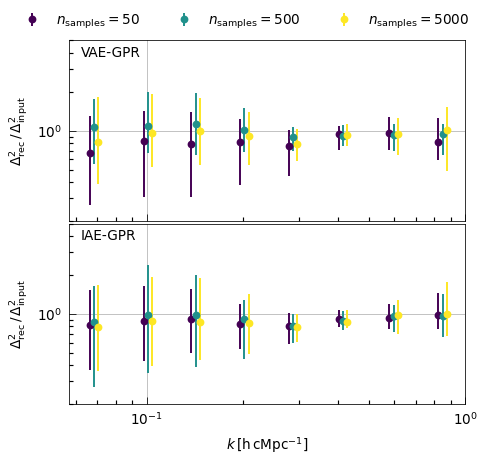

In [63]:
fig, (ax1, ax2) = plt.subplots(figsize=(3.4, 3), nrows=2, sharex=True)
colors = plt.cm.viridis(np.linspace(0, 1, 3))

total_time_hour = 100
s_m = 'mcmc'

for c, n, o in zip(colors, [50, 500, 5000], [0.97, 1, 1.03]):
    ps_eor_vae = get_ps_eor(f'simulations_results/fg_{total_time_hour}_n{n}', 'vae', s_m)
    ps_eor_iae = get_ps_eor(f'simulations_results/fg_{total_time_hour}_n{n}', 'iae', s_m)
    ps_gen.get_ps3d(kbins, c_eor).plot(ax=ax1, visible=False)
    ps_gen.get_ps3d(kbins, c_eor).plot(ax=ax2, visible=False)
    r = ps_eor_vae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)
    d, q16, q84, q2_5, q97_5, temp_unit = r.get_data(mkelvin=False)
    ax1.errorbar(o * r.k_mean, d, [d - q2_5, q97_5 - d], marker='o', c=c, label='$n_{\mathrm{samples}} = %s$' % n, ls='')
    r = ps_eor_iae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)
    d, q16, q84, q2_5, q97_5, temp_unit = r.get_data(mkelvin=False)
    ax2.errorbar(o * r.k_mean, d, [d - q2_5, q97_5 - d], marker='o', c=c, ls='')
#     (1e-6 * ps_eor_vae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax1, show68=False, marker='', c=c, label='$n_{\mathrm{samples}} = %s$' % n)
#     (1e-6 * ps_eor_iae.get_ps3d() / ps_gen.get_ps3d(kbins, c_eor)).plot(ax=ax2, show68=False, marker='', c=c)

ax1.text(0.03, 0.97, 'VAE-GPR', transform=ax1.transAxes, va='top', ha='left')
ax2.text(0.03, 0.97, 'IAE-GPR', transform=ax2.transAxes, va='top', ha='left')

ax1.set_xlabel('')
ax1.set_ylabel(r'$\Delta^2_{\rm rec}\,/\,\Delta^2_{\rm input}$')
ax2.set_ylabel(r'$\Delta^2_{\rm rec}\,/\,\Delta^2_{\rm input}$')
ax1.set_ylim(0.2, 5)
ax2.set_ylim(0.2, 5)
# ax1.set_yscale('linear')
# ax2.set_yscale('linear')
fig.legend(bbox_to_anchor=(0.5, 1.09), loc="upper center", ncol=3)
fig.tight_layout(pad=0.2)
fig.savefig('figures/ps_ratio_with_varying_nsamples_v3.pdf')

In [237]:
ps_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/cov/simu_400mpc'

def get_ps(z, zeta, tvir, rmfp):
    return pspec.SphericalPowerSpectra.load_from_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')

z = 10.1
step_parameters = 3

zetas = np.arange(10, 250, step_parameters * 5)
tvirs = np.arange(4, 6, step_parameters * 0.1)
rmfps = np.arange(5, 25, step_parameters * 2)

all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T
all_ps = np.array([get_ps(z, zeta, tvir, rmfp).data for zeta, tvir, rmfp in all_params])
ps = get_ps(z, zetas[0], tvirs[0], rmfps[0])

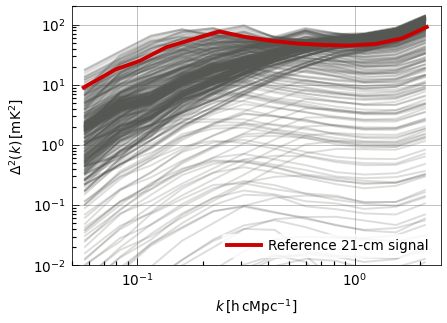

In [247]:
ps3d_ref = pspec.SphericalPowerSpectra.load_from_txt('ps_signal/ps3d_21cmFast_ref_no_ts_fluct_3params_2.txt')

fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.plot(ps.k_mean, all_ps.T * 1e6, c=psutil.black, alpha=0.2)
ps3d_ref.plot(ax=ax, label='Reference 21-cm signal', lw=2, nsigma=0, marker='', c=psutil.red)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-2, 2e2)
ax.legend()
fig.savefig('figures/450_selected_21cmFAST_simulations_and_ref_signal.pdf')
pass